In [206]:
import numpy as np 
import matplotlib as mp
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import math
import tensorflow.contrib.slim as slim
from sklearn.linear_model import LogisticRegression
import operator
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
def randomn_selection(X_train,label_train,k):
    idx = np.random.randint(X_train.shape[0], size=k)
    return X_train[idx],label_train[idx]

In [3]:
# Building the encoder
def encoder(x,weights,biases):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x,weights,biases):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

In [4]:
def trainEncoder(learning_rate,num_steps,batch_size,num_hidden_1,num_hidden_2,num_input,X_train,label_train):

    # tf Graph input (only pictures)
    X = tf.placeholder("float", [None, num_input])

    weights = {
        'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
        'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
        'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
        'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
    }
    biases = {
        'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
        'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
        'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
        'decoder_b2': tf.Variable(tf.random_normal([num_input])),
    }
    
    # Construct model
    encoder_op = encoder(X,weights,biases)
    autoencoder = decoder(encoder_op,weights,biases)

    # Prediction
    y_pred = autoencoder
    # Targets (Labels) are the input data.
    y_true = X

    # Define loss and optimizer, minimize the squared error
    loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
    
    # Start Training
    # Start a new TF session
    sess = tf.Session()

    # Run the initializer
    sess.run(init)

    # Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = randomn_selection(X_train,label_train,batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))
            
    return X,weights,biases,sess

In [ ]:
# from utils import mnist_reader
# train_dataF, train_labelsF = mnist_reader.load_mnist('data/', kind='train')
# train_dataF = train_dataF/255;


text_file = open("/Users/panktibhalani/Documents/DM/EXAM/mnist_noisy_SAMPLE5000_K20_F31.txt", "r");

lines = text_file.readlines();
mnistlabels = np.zeros(5000, dtype=np.int32)
mnistdata = np.zeros((5000,784), dtype=np.float32)
index = 0
for line in lines:
    listofpoints = line.split()
    mnistlabels[index] = listofpoints[0]
    mnistdata[index] = listofpoints[1:]
    index += 1


# Training Parameters
learning_rate = 0.01
num_steps = 100000
batch_size = 256
display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

Z,weightsF,biasesF,sessF = trainEncoder(learning_rate,num_steps,batch_size,num_hidden_1,num_hidden_2,num_input,mnistdata,mnistlabels)


Step 1: Minibatch Loss: 0.644882
Step 1000: Minibatch Loss: 0.250200
Step 2000: Minibatch Loss: 0.217316
Step 3000: Minibatch Loss: 0.211212
Step 4000: Minibatch Loss: 0.209161
Step 5000: Minibatch Loss: 0.209273
Step 6000: Minibatch Loss: 0.204560
Step 7000: Minibatch Loss: 0.209930
Step 8000: Minibatch Loss: 0.215906
Step 9000: Minibatch Loss: 0.201520
Step 10000: Minibatch Loss: 0.206979
Step 11000: Minibatch Loss: 0.214402


Original Images


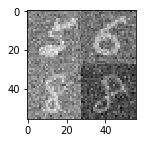

Reconstructed Images


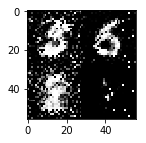

In [191]:


# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 2
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
encoedertemp =  encoder(Z,weightsF,biasesF)
autoencoder = decoder(encoedertemp,weightsF,biasesF)

for i in range(n):
    # MNIST test set
    batch_x, _ = randomn_selection(mnistdata,mnistlabels,batch_size)
    # Encode and decode the digit image
    g = sessF.run(autoencoder, feed_dict={Z: batch_x})
    
    # Display original images
    for j in range(n):
        # Draw the generated digits
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = batch_x[j].reshape([28, 28])
    # Display reconstructed images
    for j in range(n):
        # Draw the generated digits
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()

In [192]:

gtrain = sessF.run(encoedertemp, feed_dict={Z: mnistdata})
print(gtrain.shape)

(5000, 128)


In [193]:
from sklearn.cluster import KMeans
clusterring = KMeans(n_clusters=20).fit(gtrain)

# from sklearn.cluster import DBSCAN
# clusterring = DBSCAN(eps=4, min_samples=3).fit(gtrain)

array([0, 0, 0, ..., 0, 0, 0])

In [194]:
labelsresult  = clusterring.labels_
clusters = []


index = 0
clusters = {}
for label in labelsresult:
    if label in clusters:
        clusters[label].append(index)
    else:
        clusters[label] = [index]
    index += 1

In [195]:
def calculateEvaluationmatrix(hashmap, givenlabels,data):
    maxclus = []
    hasmap = {}
    ginindex = []
    MJ = []
    for key in hashmap.keys():
        temp = {}
        for datapoint in hashmap[key]:

            templabel = givenlabels[datapoint]
            if templabel in temp:
                temp[templabel] += 1
            else:
                temp[templabel] = 1
        datapercen = float(0)
        for keytemp in temp.keys():
            datapercen += ((temp[keytemp]/float(len(hashmap[key]))) ** 2)

        ginindex.append(float(1)-float(datapercen))
        MJ.append(float(len(hashmap[key])))
        maxclus.append(max(temp.items(), key=operator.itemgetter(1))[1])
    
    temp2 = {}
    for key in hashmap.keys():
        
        for datapoint in hashmap[key]:
            templabel = givenlabels[datapoint]
            
            if templabel in temp2:
                temp2[templabel].append(key)
            else:
                temp2[templabel] = [key]
    maxclus1 = []
    
    for key in temp2:
        temp = {}
        for cluster in temp2[key]:
            
            if cluster in temp:
                temp[cluster] += 1
            else:
                temp[cluster] = 1
                
      
        maxclus1.append(max(temp.items(), key=operator.itemgetter(1))[1])
    
    summation = 0
    for a in maxclus:
        summation += a
        
    summation2 = 0
    for b in maxclus1:
        summation2 += b

    ginisum = float(0)
    for i in range(len(ginindex)):
        ginisum += ginindex[i] * MJ[i]

    a1 = summation/float(data.shape[0])
    a2 = summation2/float(data.shape[0])
    
    print("Harmonic Purity: " + str((2 * a1 * a2)/float(a1 + a2)))
    print("Purity: " + str(a1))
    print("Purity: " + str(a2))
    
    
    

    print("Giniindex: " + str(ginisum/data.shape[0]))

In [196]:
calculateEvaluationmatrix(clusters,mnistlabels,gtrain)

Harmonic Purity: 0.29444885496183204
Purity: 0.3936
Purity: 0.2352
Giniindex: 0.7374997099490631


In [197]:
knowns = {}
indexes = np.random.randint(5000, size=500)
for a in indexes:
    knowns[a] = mnistlabels[a]

In [198]:
def shouldStop(oldcentroids, centroids, iterations):
    if iterations > MAX_ITERATIONS: return True
    count = 0;
    if (np.allclose(centroids,oldcentroids)):
        return True
    return False

In [199]:
def getLabels(dataset,centroids):

    hashmap = {}
    distmatrix = euclidean_distances(dataset,centroids)
    
    #print(eucdis.shape)
    for i in range(dataset.shape[0]):
     
    
        if i in knowns:
            if knowns[i] in hashmap:
                hashmap[knowns[i]].append(i)
            else:
                list1 = [i]
                hashmap[knowns[i]] = list1
        else:
    
            index = np.argmin(distmatrix[i],axis=0)
            if index in hashmap:
                hashmap[index].append(i)
            else:
                list1 = [i]
                hashmap[index] = list1
    return hashmap

In [200]:
def getCentroids(dataset, labels, k, iterations):
    new_centroids = []
    for centroid in labels.keys():
        tempa = np.mean(dataset[labels[centroid]],axis=0)
        new_centroids.append(tempa)
        
    if(len(new_centroids) < k):
        temindex = np.random.randint(dataset.shape[0], size=(k - len(new_centroids)))
        for index in temindex:
            new_centroids.append(dataset[index])
   
    return np.reshape(new_centroids,(k,dataset.shape[1]))
        

In [201]:
import operator
def kmeans(dataSet, k):
    
    idx = np.random.randint(dataSet.shape[0], size=k)
  
    centroids = dataSet[idx]

    iterations = 0
    oldCentroids = np.zeros(shape=(k,dataSet.shape[1]))
   
    while not shouldStop(oldCentroids, centroids, iterations):
        print("Running: " + str(iterations))
        oldCentroids = centroids
        iterations += 1
        labels = getLabels(dataSet, centroids)
        centroids = getCentroids(dataSet, labels, k, iterations)
        
    print("Done")
    return centroids
           

In [202]:
mnistdata.shape

(5000, 784)

In [207]:
MAX_ITERATIONS = 1000
final2 = kmeans(gtrain,20)
hasmap = getLabels(gtrain, final2)

Running: 0
20
Running: 1
20
Running: 2
20
Running: 3
20
Running: 4
20
Running: 5
20
Running: 6
20
Running: 7
20
Running: 8
20
Running: 9
20
Running: 10
20
Running: 11
20
Running: 12
20
Running: 13
20
Running: 14
20
Running: 15
20
Running: 16
20
Running: 17
20
Running: 18
20
Running: 19
20
Running: 20
20
Running: 21
20
Running: 22
20
Running: 23
20
Running: 24
20
Running: 25
20
Running: 26
20
Running: 27
20
Running: 28
20
Running: 29
20
Running: 30
20
Running: 31
20
Running: 32
20
Running: 33
20
Running: 34
20
Running: 35
20
Running: 36
20
Running: 37
20
Running: 38
20
Running: 39
20
Running: 40
20
Running: 41
20
Running: 42
20
Running: 43
20
Running: 44
20
Running: 45
20
Running: 46
20
Running: 47
20
Running: 48
20
Running: 49
20
Running: 50
20
Running: 51
20
Running: 52
20
Running: 53
20
Running: 54
20
Running: 55
20
Running: 56
20
Running: 57
20
Running: 58
20
Running: 59
20
Running: 60
20
Running: 61
20
Running: 62
20
Running: 63
20
Running: 64
20
Running: 65
20
Running: 66
20
Runni

20
Running: 520
20
Running: 521
20
Running: 522
20
Running: 523
20
Running: 524
20
Running: 525
20
Running: 526
20
Running: 527
20
Running: 528
20
Running: 529
20
Running: 530
20
Running: 531
20
Running: 532
20
Running: 533
20
Running: 534
20
Running: 535
20
Running: 536
20
Running: 537
20
Running: 538
20
Running: 539
20
Running: 540
20
Running: 541
20
Running: 542
20
Running: 543
20
Running: 544
20
Running: 545
20
Running: 546
20
Running: 547
20
Running: 548
20
Running: 549
20
Running: 550
20
Running: 551
20
Running: 552
20
Running: 553
20
Running: 554
20
Running: 555
20
Running: 556
20
Running: 557
20
Running: 558
20
Running: 559
20
Running: 560
20
Running: 561
20
Running: 562
20
Running: 563
20
Running: 564
20
Running: 565
20
Running: 566
20
Running: 567
20
Running: 568
20
Running: 569
20
Running: 570
20
Running: 571
20
Running: 572
20
Running: 573
20
Running: 574
20
Running: 575
20
Running: 576
20
Running: 577
20
Running: 578
20
Running: 579
20
Running: 580
20
Running: 581
20
Runni

In [205]:
calculateEvaluationmatrix(hasmap,mnistlabels,mnistdata)

Harmonic Purity: 0.2876135790494665
Purity: 0.3912
Purity: 0.2274
Giniindex: 0.7458682165474851
